In [1]:
# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 98):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98

# Fig1

In [30]:
### birth date, op date 없는 환자 중 소아는 거의 없음 (94,914 중 5명) -> 정석대로 birth, op date로 age 계산해서 진행
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

df = df.loc[df['age_cal'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')


#####################
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

print(f'airway tube type이 plain이 아닌 경우 제외: {len(df)}')
# age, sex, airway tube size 값이 없는 경우는 제외

df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'age, airway_tube_size 결측치 제외: {len(df)}')


# inclusion criteria : 소아 10세 미만
#df['age_cal'] = df['age_cal'] + 0.01 # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')

# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')


# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

전체 소아 (19세 미만) opid: 151651
airway tube type이 plain이 아닌 경우 제외: 77477
age, airway_tube_size 결측치 제외: 77132
10세 이상 제외 : 59352
cuffed data가 없는 경우는 제외: 45067
중복되는 hid는 첫번째 수술 외 제외: 34042


In [29]:
### birth date, op date 없는 환자 중 소아는 거의 없음 (94,914 중 5명) -> 정석대로 birth, op date로 age 계산해서 진행
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

df = df.loc[df['age_cal'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')


# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')

df = df.loc[df['airway_tube_type'] == 'plain']
print(f'airway type이 plain이 아닌 경우는 제외: {len(df)}')


df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'age, airway_tube_size 결측치 제외: {len(df)}')


df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')

전체 소아 (19세 미만) opid: 151651
중복되는 hid는 첫번째 수술 외 제외: 94914
cuffed data가 없는 경우는 제외: 56681
airway type이 plain이 아닌 경우는 제외: 38045
age, airway_tube_size 결측치 제외: 37923
10세 이상 제외 : 29974


In [34]:
### birth date, op date 없는 환자 중 소아는 거의 없음 (94,914 중 5명) -> 정석대로 birth, op date로 age 계산해서 진행
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

df = df.loc[df['age_cal'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')




df = df.loc[df['airway_tube_type'] == 'plain']
print(f'airway type이 plain이 아닌 경우는 제외: {len(df)}')




df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'age, airway_tube_size 결측치 제외: {len(df)}')



df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')


# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

전체 소아 (19세 미만) opid: 151651
cuffed data가 없는 경우는 제외: 87602
airway type이 plain이 아닌 경우는 제외: 59546
age, airway_tube_size 결측치 제외: 59351
10세 이상 제외 : 45067
중복되는 hid는 첫번째 수술 외 제외: 34042


In [69]:
### birth date, op date 없는 환자 중 소아는 거의 없음 (94,914 중 5명) -> 정석대로 birth, op date로 age 계산해서 진행
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

df = df.loc[df['age_cal'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')


#####################
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

print(f'airway tube type이 plain이 아닌 경우 제외: {len(df)}')
# age, sex, airway tube size 값이 없는 경우는 제외

df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'airway_tube_size 결측치 제외: {len(df)}')


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')


# inclusion criteria : 소아 10세 미만
#df['age_cal'] = df['age_cal'] + 0.01 # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')


# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

전체 소아 (19세 미만) opid: 151651
airway tube type이 plain이 아닌 경우 제외: 77477
age, airway_tube_size 결측치 제외: 77132
cuffed data가 없는 경우는 제외: 59351
10세 이상 제외 : 45067
중복되는 hid는 첫번째 수술 외 제외: 34042


In [72]:
59351 - 45067

14284

In [ ]:
29974 32692 33985 34011 34042

In [27]:
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['age'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')


df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))


# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')

df = df.loc[df['airway_tube_type'] == 'plain']
print(f'airway type이 plain이 아닌 경우는 제외: {len(df)}')


# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

# inclusion criteria : 소아 10세 미만
#df['age_cal'] = df['age_cal'] + 0.01 # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')


전체 소아 (19세 미만) opid: 155719
중복되는 hid는 첫번째 수술 외 제외: 94919
cuffed data가 없는 경우는 제외: 56685
airway type이 plain이 아닌 경우는 제외: 38047
10세 이상 제외 : 30076


In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['age'] < 19]
print(f'초기 전체 opid: {len(df)}')
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

print(f'airway tube type이 plain이 아닌 경우 제외: {len(df)}')
# age, sex, airway tube size 값이 없는 경우는 제외

df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'age, airway_tube_size 결측치 제외: {len(df)}')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')
#df3 = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='left', on='opid')

# inclusion criteria : 소아 10세 미만
#df['age_cal'] = df['age_cal'] + 0.01 # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')

# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')


# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

초기 전체 opid: 155719
airway tube type이 plain이 아닌 경우 제외: 78848
age, airway_tube_size 결측치 제외: 78502
10세 이상 제외 : 59352
cuffed data가 없는 경우는 제외: 45067
중복되는 hid는 첫번째 수술 외 제외: 34042


In [64]:
df[df['opid']==140924126]

,opid,sex,age,airway_tube_size,airway_tube_type,airway_lma,weight,height,age_cal,opdate,birth_date
47551,140924126,False,10,6.5,plain,NaN,56.1,154.2,9.998836,2014-09-24,2004-09-24


In [32]:
# age와 age_cal 값이 차이나는 데이터들
set1 = set(df.loc[df['age'] < 10]['opid'].values)
set2 = set(df.loc[df['age_cal'] < 10]['opid'].values)
set2 - set1

{60119113,
 100402123,
 120215116,
 140924126,
 200731100,
 200929098,
 201222093,
 210107143,
 210108148,
 210111133,
 210111166,
 210113141,
 210113147,
 210115136,
 210118133,
 210118134,
 210121144,
 210121162,
 210122155,
 210122169,
 210125128,
 210128129,
 210201134,
 210201140,
 210203163,
 210205152,
 210209131,
 210209140,
 210210139,
 210212003,
 210217139,
 210223142,
 210224134,
 210224142,
 210225129,
 210303159,
 210304151,
 210304152,
 210308151,
 210308152,
 210308154,
 210308155,
 210309133,
 210312153,
 210315129,
 210315131,
 210315133,
 210315153,
 210318127,
 210319122,
 210322127,
 210322150,
 210322151,
 210324140,
 210324145,
 210325147,
 210326126,
 210329134,
 210331129,
 210401156,
 210406134,
 210407127,
 210407134,
 210408134,
 210409136,
 210419123,
 210419145,
 210419149,
 210426126,
 210427139,
 210428125,
 210429136,
 210503124,
 210503147,
 210504133,
 210506126,
 210510140,
 210512146,
 210514150,
 210517123,
 210520141,
 210524127,
 210524128,
 2105

In [73]:
# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')

cuffed data가 없는 경우는 제외: 45067


In [77]:
# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

중복되는 hid는 첫번째 수술 외 제외: 34042


# Data preprocessing

In [2]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv, math


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

# age, sex, airway tube size 값이 없는 경우는 제외
df.dropna(subset=['age', 'airway_tube_size'], inplace=True)
df['sex'] = (df['sex'] == 'M')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')


# inclusion criteria : 소아 10세 미만
df = df.loc[df['age_cal'] < 10-0.01]
df = df.loc[df['age_cal'] > 0]
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))

In [3]:
# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')


perc = np.mean(df['cuffed'].values)
print(f'소아 10세 미만에서 cuffed ETT 사용 비율: {perc:.3f}')
print(f'소아 10세 미만 최종 opid수: {len(df)}')

중복되는 hid는 첫번째 수술 외 제외: 34042
소아 10세 미만에서 cuffed ETT 사용 비율: 0.287
소아 10세 미만 최종 opid수: 34042


In [171]:
# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

In [5]:
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed']
TARGET_VAR = 'airway_tube_size'

random.seed(98)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
c = df['opid'].values.flatten().astype(int)
#y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# 저장하기
#np.savez(f'dataset/ETT_size.npz', x=x, y=y, y_old=y_old, c=c)

In [6]:
#dat = np.load(f'dataset/ETT_size.npz')

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


In [ ]:
# label encoding for classification model: 2 -> 0, 2.5 -> 1, ... 8.5 -> 14 로 tube size x 2 - 4
df['label'] = df[TARGET_VAR].apply(lambda x: x*2-4)

for i in range(14):
    df[f'{i}'] = df['label'].apply(lambda x: 1 if x==i else 0)
    
y_label = df[[f'{i}' for i in range(14)]].values
yl_test = y_label[-ntest:]
yl_train = y_label[:ntrain]

# ETT Size

## age-based formula

In [ ]:
# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y[-ntest:]

In [192]:
print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.777
mean_squared_errors: 0.297
r2_score: 0.695
acc: 0.339
acc(+-0.5mm): 0.868


## XGBoostRegression

* 결측치 그대로 이용

In [193]:
# age 
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [4, 5, 7],#[3,4,5],
                'n_estimators': [100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = RandomizedSearchCV(n_iter=100,
                        estimator=xgb.sklearn.XGBRegressor(),
                        n_jobs=-1,
                        verbose=5,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/painstudy/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



========= found hyperparameter =========
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'colsample_bytree': 0.5}
0.8717466516356295
--------------
old model = age/4+4
--------------
explained_variance_score: 0.777
mean_squared_errors: 0.297
r2_score: 0.695
acc: 0.339
acc(+-0.5mm): 0.868
--------------
new model
--------------
explained_variance_score: 0.855
mean_squared_errors: 0.141
r2_score: 0.855
acc: 0.587
acc(+-0.5mm): 0.963
[CV 3/5] END colsample_bytree=0.5, max_depth=4, n_estimators=100, subsample=0.5;, score=0.871 total time=   1.9s
[CV 2/5] END colsample_bytree=0.5, max_depth=5, n_estimators=200, subsample=0.8;, score=0.866 total time=   3.5s
[CV 4/5] END colsample_bytree=0.5, max_depth=7, n_estimators=300, subsample=0.8;, score=0.857 total time=   7.1s
[CV 5/5] END colsample_bytree=0.8, max_depth=7, n_estimators=100, subsample=0.8;, score=0.868 total time=   3.8s
[CV 1/5] END colsample_bytree=0.5, max_depth=5, n_estimators=200, subsample=0.5;, score=0.865 total time

* 결측치 multi-imputer로 채운 경우

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [78]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [4, 5, 7],#[3,4,5],
                'n_estimators': [100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = RandomizedSearchCV(n_iter=100,
                        estimator=xgb.sklearn.XGBRegressor(),
                        n_jobs=-1,
                        verbose=3,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/painstudy/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



========= found hyperparameter =========
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'colsample_bytree': 0.8}
0.871740670673633
--------------
new model
--------------
explained_variance_score: 0.857
mean_squared_errors: 0.140
r2_score: 0.857
acc: 0.590
acc(+-0.5mm): 0.964


### cuffed model

In [ ]:
train_mask = (x_train[:,4] == 1)
test_mask = (x_test[:,4] == 1)

x_train_c = x_train[train_mask,0:4]
y_train_c = y_train[train_mask,0:4]

### plotting

In [197]:
xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        cvals.append(sum((y_pred == x) & (y_test == y)))
        cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals_old, label='4+AGE/4')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.plot([2.5,8], [2,7.5], '--k', alpha=0.1)
plt.plot([2,7.5], [2.5,8], '--k', alpha=0.1)
plt.savefig('old_tube-size.png')
plt.close()

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='blue', alpha=0.5, s=cvals, label='XGBR')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.plot([2.5,8], [2,7.5], '--k', alpha=0.1)
plt.plot([2,7.5], [2.5,8], '--k', alpha=0.1)
plt.savefig('xgbr_tube-size.png')
plt.close()

In [ ]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'regression model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

## RandomForest

In [76]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [81]:
from sklearn.ensemble import RandomForestRegressor

SEED = 0
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 5, 7],#[3,4,5],
                'max_leaf_nodes': [3, 5, 7],
                'n_estimators': [50, 100, 200, 300],
                'max_features': ['auto', 'sqrt', 'log2'],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'min_samples_split': [2,3,5],
                'min_samples_leaf': [1,2,3],
               'bootstrap': [True, False]
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = GridSearchCV(n_iter=500,
                        estimator=RandomForestRegressor(random_state = SEED),
                        n_jobs=-1,
                        verbose=5,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

Fitting 5 folds for each of 100 candidates, totalling 500 fits

========= found hyperparameter =========
{'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': True}
0.8732191690919636


In [83]:
rfr = RandomForestRegressor(random_state=SEED,  n_estimators= 300, min_samples_split= 3, min_samples_leaf= 1, max_features='sqrt', max_depth= 7, bootstrap= True)
rfr.fit(x_train_imputed, y_train)
y_pred = rfr.predict(x_test_imputed).flatten()

y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
new model
--------------
explained_variance_score: 0.859
mean_squared_errors: 0.139
r2_score: 0.858
acc: 0.586
acc(+-0.5mm): 0.966


## SVM

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [8]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


SEED = 98
param_grid = {'C': [1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 

nfold = 4
gs = GridSearchCV(estimator=SVR(),
                  n_jobs=-1,
                  refit=True,
                  verbose=3,
                  param_grid=param_grid, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")


y_pred = gs.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV 2/4] END .......C=10, gamma=0.1, kernel=rbf;, score=0.865 total time= 2.3min
[CV 3/4] END .......C=10, gamma=0.1, kernel=rbf;, score=0.872 total time= 2.3min
[CV 1/4] END .......C=10, gamma=0.1, kernel=rbf;, score=0.878 total time= 2.3min
[CV 4/4] END .......C=10, gamma=0.1, kernel=rbf;, score=0.873 total time= 2.4min
[CV 4/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.839 total time= 2.8min
[CV 3/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.834 total time= 2.9min
[CV 1/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.841 total time= 2.9min
[CV 2/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.828 total time= 2.9min
[CV 2/4] END .......C=1, gamma=0.01, kernel=rbf;, score=0.874 total time=  45.8s
[CV 1/4] END .....C=100, gamma=0.01, kernel=rbf;, score=0.883 total time= 2.2min
[CV 3/4] END ......C=1, gamma=0.001, kernel=rbf;, score=0.879 total time=  46.4s
[CV 4/4] END .....C=100, gamma=0.01, kernel=rbf;

Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/painstudy/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 575, in run
    self.flag_executor_shutting_down()
  File "/home/painstudy/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 770, in flag_executor_shutting_down
    self.kill_workers(reason="executor shutting down")
  File "/home/painstudy/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 781, in kill_workers
    recursive_terminate(p)
  File "/home/painstudy/.local/lib/python3.8/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/home/painstudy/.local/lib/python3.8/site-packages/joblib/externals/loky/backend/utils.py", line 53,

KeyboardInterrupt: 

In [11]:
svr = SVR(C=1, gamma=0.001, kernel='rbf')
svr.fit(x_train_imputed, y_train)

y_pred = svr.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
new model
--------------
explained_variance_score: 0.858
mean_squared_errors: 0.144
r2_score: 0.858
acc: 0.591
acc(+-0.5mm): 0.961


## ANN

In [84]:
from keras import losses, metrics
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interp
import os, sys, pickle, shutil
import pandas as pd
import numpy as np
import random, datetime, time
from sklearn.model_selection import KFold


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 98):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [105]:
x_train.shape

(35971, 5)

In [104]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(df.loc[:ntrain-1,INPUT_VARS])
x_test = sc.transform(df.loc[ntrain:,INPUT_VARS])

In [106]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [88]:
# save model
#odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_{nfold}fold'
odir_f = f'DNN_size'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)

In [115]:
dense_node = 512
dropout = 0.3
batch_size = 64
learning_rate = 0.001

# model
inp = Input(shape=(x_train.shape[1],))
out = inp

out = Dense(dense_node, activation='relu')(out)
out = BatchNormalization()(out)
out = Dropout(dropout)(out)
out = Dense(dense_node, activation='relu')(out)
out = Dropout(dropout)(out)
out = Dense(1, activation=None)(out)

model = Model(inputs=[inp], outputs=[out])
#model.save_weights(f'{odir}/initinp.l_weights.hdf5')

weightcache = f"{odir}/weights.hdf5"
model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=["mean_absolute_error"])
hist = model.fit(x_train_imputed, y_train, validation_split=0.2, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                        callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                    EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])

model.load_weights(weightcache)
y_pred = model.predict(x_test_imputed).flatten()

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
449/450 [============================>.] - ETA: 0s - loss: 0.9451 - mean_absolute_error: 0.5390
Epoch 00001: val_loss improved from inf to 0.63609, saving model to result/DNN_size/weights.hdf5
450/450 [==============================] - 3s 5ms/step - loss: 0.9441 - mean_absolute_error: 0.5388 - val_loss: 0.6361 - val_mean_absolute_error: 0.2973
Epoch 2/100
444/450 [============================>.] - ETA: 0s - loss: 0.3555 - mean_absolute_error: 0.4044
Epoch 00002: val_loss improved from 0.63609 to 0.27092, saving model to result/DNN_size/weights.hdf5
450/450 [==============================] - 2s 5ms/step - loss: 0.3538 - mean_absolute_error: 0.4039 - val_loss: 0.2709 - val_mean_absolute_error: 0.2828
Epoch 3/100
445/450 [============================>.] - ETA: 0s - loss: 0.2866 - mean_absolute_error: 0.3900
Epoch 00003: val_loss improved from 0.27092 to 0.17374, saving model to result/DNN_size/weights.hdf5
450/450 [==============================] - 2s 4ms/step - loss: 0.2860 -

In [116]:
y_pred = model.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2

print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
print(f'acc: {np.mean(y_pred==y_test):.3f}')
print(f'acc(+-0.5mm): {np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5)):.3f}')

explained_variance_score: 0.843
mean_squared_errors: 0.153
r2_score: 0.840
acc: 0.567
acc(+-0.5mm): 0.955


# Insertion depth

In [ ]:
df.isnull().sum()

(array([7.0000e+00, 4.5000e+01, 2.5100e+02, 2.2040e+03, 6.8630e+03,
        1.4196e+04, 1.0387e+04, 5.9750e+03, 3.6700e+02, 3.0000e+01]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

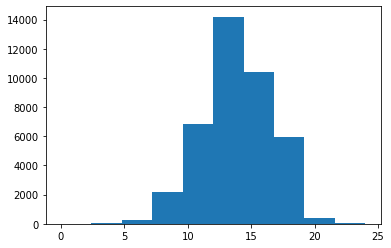

In [199]:
dff = df.dropna(subset=['fixed'])
depths = dff['fixed'].values
plt.hist(depths)

In [137]:
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed', 'airway_tube_size']
TARGET_VAR = 'fixed'

seed_everything(SEED)
df.dropna(subset=['fixed'], inplace=True)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

## PALS guideline

In [145]:
OLD_VAR = 'old_depth1'
# OLD_VAR = 'old_tube_size'
df[OLD_VAR] = 3 * df['airway_tube_size']
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = 3 * ETT size')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = 3 * ETT size
--------------
explained_variance_score: 0.603
mean_squared_errors: 3.097
r2_score: 0.569


In [144]:
OLD_VAR = 'old_depth1'
# OLD_VAR = 'old_tube_size'
df[OLD_VAR] = 3 * df['old_tube_size']
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = 3 * age-based ETT size')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = 3 * age-based ETT size
--------------
explained_variance_score: 0.624
mean_squared_errors: 2.808
r2_score: 0.609


In [143]:
OLD_VAR = 'old_depth1'
# OLD_VAR = 'old_tube_size'
df[OLD_VAR] = df['age'] / 2 + 12
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = age / 2 + 12')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = age / 2 + 12
--------------
explained_variance_score: 0.592
mean_squared_errors: 2.977
r2_score: 0.585


In [131]:
from sklearn.metrics import mean_absolute_error

# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [4, 5, 7],#[3,4,5],
                'n_estimators': [100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = RandomizedSearchCV(n_iter=100,
                        estimator=xgb.sklearn.XGBRegressor(),
                        n_jobs=-1,
                        verbose=5,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')

/home/painstudy/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 36 candidates, totalling 180 fits

========= found hyperparameter =========
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'colsample_bytree': 0.5}
0.7925042013962639
--------------
new model
--------------
explained_variance_score: 0.790
mean_squared_errors: 1.561
r2_score: 0.790


In [133]:
print(f'acc(+-1cm): {np.mean((y_pred >= y_test-1) & (y_pred <= y_test+1)):.3f}')

acc(+-1cm): 0.700


In [134]:
np.min(y_pred), np.max(y_pred), np.min(y_test), np.max(y_test)

(7.589564, 20.347792, 1.5, 24.0)

In [ ]:
plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='blue', alpha=0.5, s=cvals, label='GBRT')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.savefig('new.png')
plt.close()

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv, math


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

# age, sex, airway tube size 값이 없는 경우는 제외
df.dropna(subset=['age', 'airway_tube_size'], inplace=True)
df['sex'] = (df['sex'] == 'M')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

# inclusion criteria : 소아 10세 미만
df = df.loc[df['age_cal'] < 10-0.01]
df = df.loc[df['age_cal'] > 0]
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

perc = np.mean(df['cuffed'].values)
print(f'소아 10세 미만에서 cuffed ETT 사용 비율: {perc:.3f}')
print(f'소아 10세 미만 최종 opid수: {len(df)}')

# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)


# fixed depth를 output
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed', 'airway_tube_size']
TARGET_VAR = 'fixed'


random.seed(98)
#seed_everything(SEED)
df.dropna(subset=['fixed'], inplace=True)
df = df.loc[df['fixed']>=12]
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)
c = df['opid'].values.flatten().astype(int)

# 저장하기
pickle.dump(df, open(f'dataset/ETT_depth_12','wb'))
np.savez(f'dataset/ETT_depth_12.npz', x=x, y=y, c=c)


# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

# Comparison of each model

In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv

In [2]:
dat = np.load(f'dataset/ETT_size.npz')
x, y = dat['x'], dat['y']
y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

x_train: (27234, 5), x_test: (6808, 5)


In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [28]:
# xgbr model
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')
y_xgbr = xgbr.predict(x_test).flatten()
y_xgbr1 = np.round(y_xgbr * 2) / 2
acc3 = np.mean((y_xgbr1 >= y_test-0.5) & (y_xgbr1 <= y_test+0.5))
print(f'xgbr model acc: {np.mean(y_xgbr1==y_test):.3f}, acc(+-0.5mm): {acc3:.3f}')


# RF model
rfr = pickle.load(open(f'result/size/acc1-0.595_acc3-0.963_RF_10fold/gridSearch','rb'))
y_rfr = rfr.predict(x_test_imputed).flatten()
y_rfr1 = np.round(y_rfr * 2) / 2
acc3 = np.mean((y_rfr1 >= y_test-0.5) & (y_rfr1 <= y_test+0.5))
print(f'rf model acc: {np.mean(y_rfr1==y_test):.3f}, acc(+-0.5mm): {acc3:.3f}')

# ensemble
y_ens = (y_xgbr*3 + y_rfr*2) / 5
y_ens = np.round(y_ens * 2) / 2
acc3 = np.mean((y_ens >= y_test-0.5) & (y_ens <= y_test+0.5))
print(f'ensemble model acc: {np.mean(y_ens==y_test):.3f}, acc(+-0.5mm): {acc3:.3f}')


/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


xgbr model acc: 0.601, acc(+-0.5mm): 0.966
rf model acc: 0.595, acc(+-0.5mm): 0.963
ensemble model acc: 0.598, acc(+-0.5mm): 0.965


In [24]:
np.mean(y_xgbr==y_rbr)

0.8858695652173914

## Cole's formula (age 내림으로 수정)

In [ ]:
5 -> 5/4 + 4 = 5.25 -> 10.5 -> round down 10/2 = 5
6 -> 6/4 + 4 = 5.5 -> 11 / 2 = 5.5
7 -> 7/4 + 4 = 5.75 -> 11.5 -> 11/2=5.5

In [49]:
import math
df_cole = pd.DataFrame({'age_cal':x_test[:,0], 'cuffed':x_test[:,4]})
df_cole['age'] = df_cole['age_cal'].apply(lambda x: math.floor(x))

OLD_VAR = 'old_tube_size'
df_cole[OLD_VAR] = df_cole['age'].apply(lambda x: math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df_cole[OLD_VAR] = df_cole.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

y_old = df_cole[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

In [50]:
print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.817
mean_squared_errors: 0.321
mean_absolute_errors: 0.449
r2_score: 0.676
acc: 0.276
acc(+-0.5mm): 0.841


In [64]:
age_mask = (x_test[:,0] >= 2)

y_test_old1 = y_test_old[age_mask]
y_test1 = y_test[age_mask]


print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test1, y_test_old1):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test1, y_test_old1):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test1, y_test_old1):.3f}')
print(f'r2_score: {r2_score(y_test1, y_test_old1):.3f}')
# accuracy
acc1 = np.mean(y_test_old1==y_test1)
acc3 = np.mean((y_test_old1 >= y_test1-0.5) & (y_test_old1 <= y_test1+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.629
mean_squared_errors: 0.352
mean_absolute_errors: 0.478
r2_score: 0.188
acc: 0.247
acc(+-0.5mm): 0.815


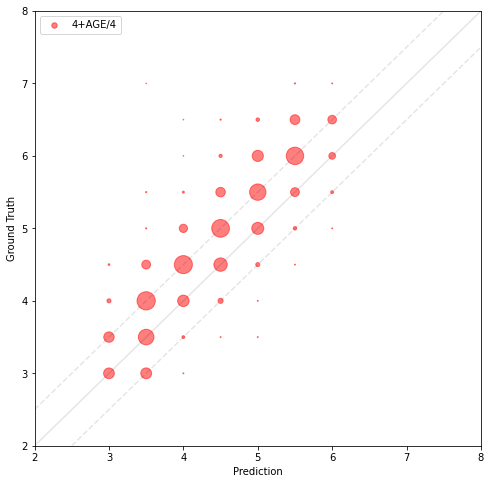

In [66]:
xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        #cvals.append(sum((y_pred == x) & (y_test == y)))
        cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
#cvals = np.array(cvals) / 2
cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals_old, label='4+AGE/4')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.plot([2.5,8], [2,7.5], '--k', alpha=0.1)
plt.plot([2,7.5], [2.5,8], '--k', alpha=0.1)

In [42]:
import math

# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

SEED = 98
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed']
TARGET_VAR = 'airway_tube_size'


random.seed(SEED)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
c = df['opid'].values.flatten().astype(int)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)



# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]


print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.805
mean_squared_errors: 0.342
mean_absolute_errors: 0.459
r2_score: 0.655
acc: 0.279
acc(+-0.5mm): 0.823


# Demography

In [73]:
np.mean(np.isnan(x[:,3])), np.mean(np.isnan(x[:,2]))

(0.02861171494036778, 0.01304271194406909)

In [49]:
height = x[:,3]
weight = x[:,2]

np.sum(weight>250), np.sum(height>200), np.sum(height<30), np.sum(weight<1)

(1, 2, 144, 2)

In [50]:
height[height>200], weight[height>200], height[weight>200],    # height outlier는 train, test 하나씩, weight는 train에 하나


(array([236.7, 874.2]), array([28.8, 12.7]), array([90.]), array([1301.]))

weight>250: 1(0.003%), height>200: 2(0.006%)


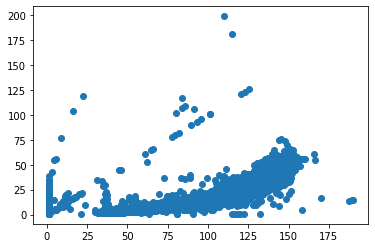

In [42]:
# outlier 제거 (invalid value)
height = x[:,3]
weight = x[:,2]

print(f'weight>250: {np.sum(weight>250)}({np.mean(weight>250)*100:.3f}%), height>200: {np.sum(height>200)}({np.mean(height>200)*100:.3f}%)') 
out_mask = (height<200) & (weight<250)
#out_mask = np.logical_and(height<200, weight<250)
#print(np.sum(~out_mask))

height = height[out_mask]
weight = weight[out_mask]

plt.scatter(height, weight)
#np.sum(height>200)
#height = height[height<200]
#np.max(height)

In [44]:
np.nanmax(x_train[:,2]), np.nanmax(x_test[:,2]), np.nanmax(x_train[:,3]), np.nanmax(x_test[:,3])

(1301.0, 123.0, 236.7, 874.2)

In [6]:
print(f'total x_train: {len(x_train)}, x_test: {len(x_test)}')
# age
print(f'[age] \ntrain - mean : {np.mean(x_train[:,0]):.2f}, std : {np.std(x_train[:,0]):.2f}')
print(f'test - mean : {np.mean(x_test[:,0]):.2f}, std : {np.std(x_test[:,0]):.2f}\n')

# sex
print(f'[sex] \ntrain - female : {len(x_train)-np.sum(x_train[:,1])}({1-np.mean(x_train[:,1]):.3f}), male: {np.sum(x_train[:,1])}({np.mean(x_train[:,1]):.3f})')
print(f'test - female : {len(x_test)-np.sum(x_test[:,1])}({1-np.mean(x_test[:,1]):.3f}), male: {np.sum(x_test[:,1])}({np.mean(x_test[:,1]):.3f})\n')


# weight
print(f'[weight]  mean : {np.nanmean(x_train[:,2]):.2f}, std : {np.nanstd(x_train[:,2]):.2f}')
print(f'test - mean : {np.nanmean(x_test[:,2]):.2f}, std : {np.nanstd(x_test[:,2]):.2f}\n')

# height
print(f'[height]  mean : {np.nanmean(x_train[:,3]):.2f}, std : {np.nanstd(x_train[:,3]):.2f}')
print(f'test - mean : {np.nanmean(x_test[:,3]):.2f}, std : {np.nanstd(x_test[:,3]):.2f}\n')

# cuff
print(f'[cuff] cuffed : {np.sum(x_train[:,4])}({np.mean(x_train[:,4]):.3f}), uncuffed: {len(x_train)-np.sum(x_train[:,4])}({1-np.mean(x_train[:,4]):.3f})')
print(f'test - female : {np.sum(x_test[:,4])}({1-np.mean(x_test[:,4]):.3f}), male: {len(x_test)-np.sum(x_test[:,4])}({len(x_test)-np.mean(x_test[:,4]):.3f})\n')

# tube size
print(f'[tube size] \ntrain - mean : {np.mean(y_train):.2f}, std : {np.std(y_train):.2f}')
print(f'test - mean : {np.mean(y_test):.2f}, std : {np.std(y_test):.2f}\n')

total x_train: 27234, x_test: 6808
[age] 
train - mean : 3.51, std : 2.95
test - mean : 3.46, std : 2.92

[sex] 
train - female : 11271.0(0.414), male: 15963.0(0.586)
test - female : 2846.0(0.418), male: 3962.0(0.582)

[weight]  mean : 15.58, std : 12.33
test - mean : 15.47, std : 9.53

[height]  mean : 92.80, std : 26.42
test - mean : 92.50, std : 27.78

[cuff] cuffed : 7827.0(0.287), uncuffed: 19407.0(0.713)
test - female : 0.715, male: 6807.715

[tube size] 
train - mean : 4.75, std : 1.01
test - mean : 4.74, std : 0.99



In [59]:
height = x[:,3]
weight = x[:,2]

x[np.where((height>175) | (height<30))[0],3] = None
x[np.where((weight>150) | (weight<1))[0],2] = None

x_train = x[:ntrain]
x_test = x[-ntest:]


# weight
print(f'[weight]  mean : {np.nanmean(x_train[:,2]):.2f}, std : {np.nanstd(x_train[:,2]):.2f}')
print(f'test - mean : {np.nanmean(x_test[:,2]):.2f}, std : {np.nanstd(x_test[:,2]):.2f}\n')

# height
print(f'[height]  mean : {np.nanmean(x_train[:,3]):.2f}, std : {np.nanstd(x_train[:,3]):.2f}')
print(f'test - mean : {np.nanmean(x_test[:,3]):.2f}, std : {np.nanstd(x_test[:,3]):.2f}\n')

[weight]  mean : 15.52, std : 9.39
test - mean : 15.47, std : 9.53

[height]  mean : 93.16, std : 25.81
test - mean : 92.79, std : 25.44



In [58]:
np.nanmax(x_train[:,2]), np.nanmax(x_test[:,2]), np.nanmax(x_train[:,3]), np.nanmax(x_test[:,3])

(199.0, 123.0, 189.9, 157.8)

In [61]:
# cuff
print(f'[cuff] cuffed : {np.sum(x_train[:,4])}({np.mean(x_train[:,4]):.3f}), uncuffed: {len(x_train)-np.sum(x_train[:,4])}({1-np.mean(x_train[:,4]):.3f})')
print(f'test - female : {np.sum(x_test[:,4])}({np.mean(x_test[:,4]):.3f}), male: {len(x_test)-np.sum(x_test[:,4])}({1-np.mean(x_test[:,4]):.3f})\n')

[cuff] cuffed : 7827.0(0.287), uncuffed: 19407.0(0.713)
test - female : 1941.0(0.285), male: 4867.0(0.715)



## Sex 별 demo

In [77]:
print(f'total x_train: {len(x_train)}, x_test: {len(x_test)}')
m_mask = (x[:,1]==1)
f_mask = (x[:,1]==0)

# age
print(f'[age] \ntrain - (male) mean : {np.mean(x[m_mask,0]):.2f}, std : {np.std(x[m_mask,0]):.2f}\t\n(female) mean : {np.mean(x[f_mask,0]):.2f}, std: {np.std(x[f_mask,0]):.2f}')

total x_train: 27234, x_test: 6808
[age] 
train - (male) mean : 3.43, std : 2.93	
(female) mean : 3.60, std: 2.97


In [ ]:
print(f'total x_train: {len(x_train)}, x_test: {len(x_test)}')
m_mask = (x[:,1]==1)
f_mask = (x[:,1]==0)

# age
print(f'[age] \ntrain - (male) mean : {np.mean(x_train[m_mask,0]):.2f}, (female) mean : {np.mean(x_train[f_mask,0]):.2f}')
print(f'test - mean : {np.mean(x_test[:,0]):.2f}, std : {np.std(x_test[:,0]):.2f}\n')

# sex
print(f'[sex] \ntrain - female : {len(x_train)-np.sum(x_train[:,1])}({1-np.mean(x_train[:,1]):.3f}), male: {np.sum(x_train[:,1])}({np.mean(x_train[:,1]):.3f})')
print(f'test - female : {len(x_test)-np.sum(x_test[:,1])}({1-np.mean(x_test[:,1]):.3f}), male: {np.sum(x_test[:,1])}({np.mean(x_test[:,1]):.3f})\n')


# weight
print(f'[weight]  mean : {np.nanmean(x_train[:,2]):.2f}, std : {np.nanstd(x_train[:,2]):.2f}')
print(f'test - mean : {np.nanmean(x_test[:,2]):.2f}, std : {np.nanstd(x_test[:,2]):.2f}\n')

# height
print(f'[height]  mean : {np.nanmean(x_train[:,3]):.2f}, std : {np.nanstd(x_train[:,3]):.2f}')
print(f'test - mean : {np.nanmean(x_test[:,3]):.2f}, std : {np.nanstd(x_test[:,3]):.2f}\n')

# cuff
print(f'[cuff] cuffed : {np.sum(x_train[:,4])}({np.mean(x_train[:,4]):.3f}), uncuffed: {len(x_train)-np.sum(x_train[:,4])}({1-np.mean(x_train[:,4]):.3f})')
print(f'test - female : {np.sum(x_test[:,4])}({1-np.mean(x_test[:,4]):.3f}), male: {len(x_test)-np.sum(x_test[:,4])}({len(x_test)-np.mean(x_test[:,4]):.3f})\n')

# tube size
print(f'[tube size] \ntrain - mean : {np.mean(y_train):.2f}, std : {np.std(y_train):.2f}')
print(f'test - mean : {np.mean(y_test):.2f}, std : {np.std(y_test):.2f}\n')

### Imputation 확인

In [78]:
df_train

,0,1,2,3,4
0,6.765368,0.0,20.65,116.0,0.0
1,1.582510,1.0,10.20,82.0,1.0
2,7.263667,0.0,24.15,121.5,1.0
3,1.056832,0.0,9.80,73.7,1.0
4,4.438147,0.0,19.90,99.0,0.0
...,...,...,...,...,...
27229,5.774246,1.0,24.75,118.6,0.0
27230,0.309383,1.0,4.20,49.7,1.0
27231,1.451091,1.0,9.70,83.9,1.0
27232,1.273127,1.0,14.00,90.0,0.0


In [84]:
df_train.loc[114]

0     6.987139
1     0.000000
2    28.000000
3          NaN
4     0.000000
Name: 114, dtype: float64

In [83]:
df_train = pd.DataFrame(x_train)
df_train[3].isnull().tolist().index(1)

114

In [85]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [86]:
df_train_imp = pd.DataFrame(x_train_imputed)
df_train_imp.loc[114]

0      6.987139
1      0.000000
2     28.000000
3    121.907880
4      0.000000
Name: 114, dtype: float64

# Size - input correlation

## Spearman

In [123]:
height

array([ 94.3, 116.4,  82.5, ...,  77.2,  98.2, 120. ])

In [129]:
height[height<30]

array([ 6.7 , 21.  ,  1.  ,  2.2 ,  4.55,  8.8 ,  1.  ,  1.  ,  1.  ,
        1.  , 12.2 ,  1.  ,  9.5 ,  1.  ,  4.9 , 10.1 ,  1.  ,  1.  ,
        1.  ,  1.  , 13.4 , 13.  ,  9.6 ,  1.  , 17.55,  1.  ,  1.  ,
        1.  ,  1.  ,  1.  ,  1.  ])

array([ True,  True,  True, ...,  True,  True,  True])

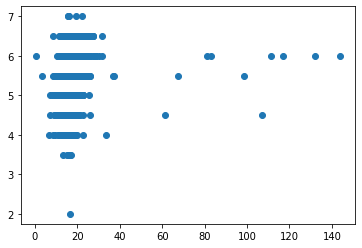

In [165]:
age = x_test_imputed[:,0]
height, weight = x_test_imputed[:,3], x_test_imputed[:,2]
mask = np.logical_and(np.logical_and(height<200, height>30), age>2)

weight = weight[mask]
height = height[mask]


bmi = weight / (height/100) / (height/100)

plt.scatter(bmi, y_test[mask])

In [104]:
x_test[:,0]

array([2.74612073, 6.91047729, 1.72488141, ..., 1.42644955, 3.50452097,
       5.9001896 ])

In [107]:
import scipy.stats as stats

rho, pval = stats.pearsonr(x_test[:,0], y_test)
rho, pval

(0.8723924366319188, 0.0)

(array([   6.,   40.,  471.,  726., 1021., 1207., 1085.,  904.,  972.,
         376.]),
 array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ]),
 <BarContainer object of 10 artists>)

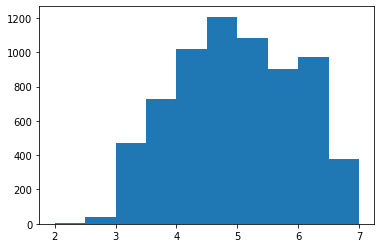

In [166]:
plt.hist(y_test)

In [82]:
import scipy.stats as stats
stats.pearsonr(x_test[:,0], y_test)

(0.8723924366319188, 0.0)

In [81]:
import scipy.stats as stats
stats.pearsonr(x_test[:,1], y_test)

(-0.0100779619100062, 0.405743655645806)

In [84]:
import scipy.stats as stats
stats.pearsonr(x_test_imputed[:,2], y_test)

(0.7946105737089508, 0.0)

In [85]:
import scipy.stats as stats
stats.pearsonr(x_test_imputed[:,3], y_test)

(0.8197764526370859, 0.0)

In [86]:
import scipy.stats as stats
stats.pearsonr(x_test[:,4], y_test)

(-0.059154626667131574, 1.0381533516208097e-06)

In [89]:
import scipy.stats as stats
stats.spearmanr(x_test[:,1], y_test)

SpearmanrResult(correlation=-0.01249872268809375, pvalue=0.30248076059007767)

In [ ]:
# 즉, depth와 

# Calculator

In [ ]:
import xgboost as xgb

xgbr = xgb.XGBRegressor()
xgbr.load_model('size_model.model')

def 